In [1]:
import astropy.units as u
from tdsat_telescope import load_telescope_parameters
from tdsat_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure
from tdsat_neff import get_neff
from bbmag import bb_abmag_fluence
import numpy as np
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
from bbmag import bb_abmag_fluence, bb_abmag

In [3]:
siglimit = 10. # sigma
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()


Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


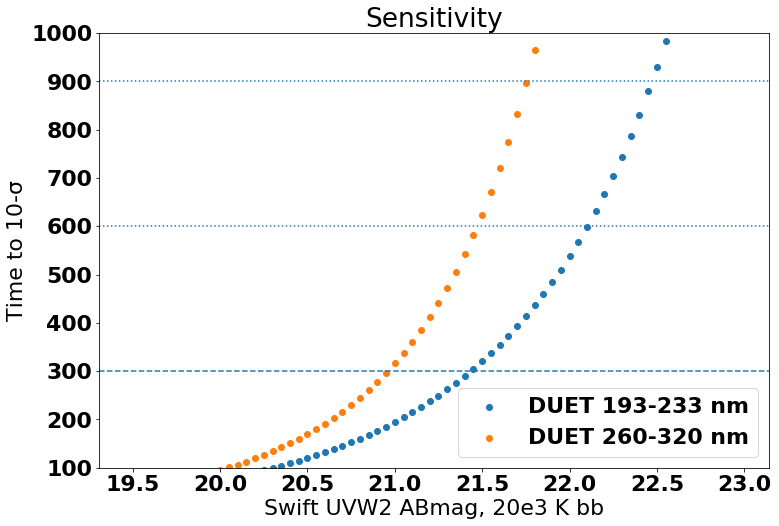

In [17]:
light=True
siglimit=10


exp1 = []
exp2 = []
sm = []
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))

for swiftmag in np.arange(19.5, 23, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)

    
    
    
    exp1 = np.append(exp1, exposure1)
    exp2 = np.append(exp2, exposure2)
    sm = np.append(sm, swiftmag)
    
    
plt.figure(figsize=[12, 8])
plt.scatter(sm, exp1, label='DUET 193-233 nm')
plt.scatter(sm, exp2, label='DUET 260-320 nm')

plt.ylim([100, 1000])
plt.axhline(300, linestyle = '--')
plt.axhline(600, linestyle = ':')
plt.axhline(900, linestyle = ':')


plt.ylabel('Time to {}-σ'.format(siglimit))
plt.xlabel('Swift UVW2 ABmag, 20e3 K bb')
plt.title('Sensitivity')
plt.legend()
plt.show()

Sky background rate per pixel band1: 0.002994760734760334 1 / s
Sky background rate per pixel band2: 0.08555773305508275 1 / s


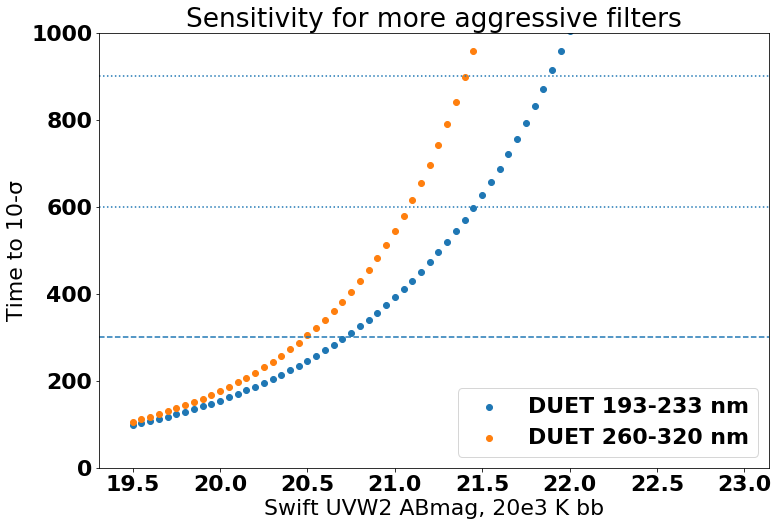

In [18]:
light=False
siglimit=10


exp1 = []
exp2 = []
sm = []
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))

for swiftmag in np.arange(19.5, 23, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)

    exp1 = np.append(exp1, exposure1)
    exp2 = np.append(exp2, exposure2)
    sm = np.append(sm, swiftmag)
plt.figure(figsize=[12, 8])
plt.scatter(sm, exp1, label='DUET 193-233 nm')
plt.scatter(sm, exp2, label='DUET 260-320 nm')

plt.ylim([0, 1000])
plt.axhline(300, linestyle = '--')

plt.axhline(600, linestyle = ':')
plt.axhline(900, linestyle = ':')


plt.ylabel('Time to {}-σ'.format(siglimit))
plt.xlabel('Swift UVW2 ABmag, 20e3 K bb')
plt.title('Sensitivity for more aggressive filters')
plt.legend()
plt.show()

Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


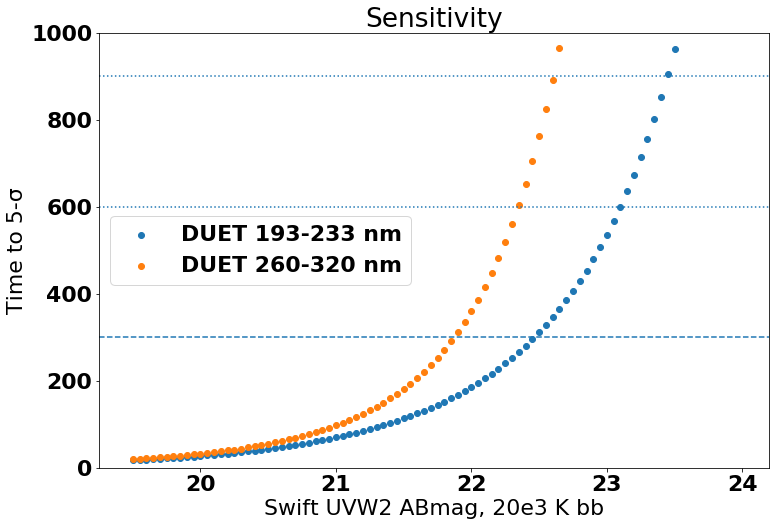

In [19]:
light=True
siglimit=5


exp1 = []
exp2 = []
sm = []
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))

for swiftmag in np.arange(19.5, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence




    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)

    exp1 = np.append(exp1, exposure1)
    exp2 = np.append(exp2, exposure2)
    sm = np.append(sm, swiftmag)
plt.figure(figsize=[12, 8])
plt.scatter(sm, exp1, label='DUET 193-233 nm')
plt.scatter(sm, exp2, label='DUET 260-320 nm')

plt.ylim([0, 1000])
plt.axhline(300, linestyle = '--')

plt.axhline(600, linestyle = ':')
plt.axhline(900, linestyle = ':')


plt.ylabel('Time to {}-σ'.format(siglimit))
plt.xlabel('Swift UVW2 ABmag, 20e3 K bb')
plt.title('Sensitivity')
plt.legend()
plt.show()

In [20]:
light=True



for swiftmag in np.arange(18, 25, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    if (band2_rate.value < 1.0):
        print('260-320 nm Photometric Zero Point: {}'.format(swiftmag))
        break

for swiftmag in np.arange(18, 25, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    if (band1_rate.value < 1.0):
        print('193-233 nm Photometric Zero Point: {}'.format(swiftmag))
        break

        





260-320 nm Photometric Zero Point: 20.650000000000038
193-233 nm Photometric Zero Point: 20.75000000000004


In [23]:
light=True
siglimit=10


exp1 = []
exp2 = []
sm = []
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))

for swiftmag in np.arange(20, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)
    if (exposure2.value >300.):
        print('260-320 nm 300-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break

        
for swiftmag in np.arange(20, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)
    if (exposure2.value >600.):
        print('260-320 nm 600-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break

siglimit=5

for swiftmag in np.arange(20, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)
    if (exposure2.value >300.):
        print('260-320 nm 300-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break

        
for swiftmag in np.arange(20, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)
    if (exposure2.value >600.):
        print('260-320 nm 600-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break





Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s
260-320 nm 300-s mag limit at 10-σ: 21.000000000000014
260-320 nm 600-s mag limit at 10-σ: 21.50000000000002
260-320 nm 300-s mag limit at 5-σ: 21.900000000000027
260-320 nm 600-s mag limit at 5-σ: 22.350000000000033


In [25]:
light=True
siglimit=10


exp1 = []
exp2 = []
sm = []
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))



for swiftmag in np.arange(21, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    if (exposure1.value >300.):
        print('193-233 nm 300-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))

        break


for swiftmag in np.arange(21, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    if (exposure1.value >600.):
        print('193-233 nm 600-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break

siglimit=5
for swiftmag in np.arange(21, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    if (exposure1.value >300.):
        print('193-233 nm 300-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))

        break


for swiftmag in np.arange(21, 24, 0.05):
    band1_fluence, band2_fluence = bb_abmag_fluence(swiftmag=swiftmag*u.ABmag, bbtemp=20e3*u.K, light=light)
    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence

    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    if (exposure1.value >600.):
        print('193-233 nm 600-s mag limit at {}-σ: {}'.format(siglimit, swiftmag))
        break


Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s
193-233 nm 300-s mag limit at 10-σ: 21.450000000000006
193-233 nm 600-s mag limit at 10-σ: 22.150000000000016
193-233 nm 300-s mag limit at 5-σ: 22.50000000000002
193-233 nm 600-s mag limit at 5-σ: 23.10000000000003
